# Simulation of a Single-Stage Vapor Compression Machine

In this notebook, we will model a single-stage vapor compression machine (VCM) for cooling air in a building's air conditioning system. The aim is to predict the steady-state performance of the VCM under the design conditions of the air conditioning system. (By tuning operating conditions, or possibly changing the number of rows of the evaporator and/or condenser, we can try to match the cooling capacity and the state of air leaving the DX cooling coil (air evaporator) with the design requirements. 

In [1]:
import warnings
from hvac import Quantity
from hvac.fluids import Fluid, CoolPropWarning, HumidAir, CP_HUMID_AIR
from hvac.heat_transfer.heat_exchanger.fin_tube import (
    PlainFinTubeCounterFlowAirEvaporator,
    PlainFinTubeCounterFlowAirCondenser
)
from hvac.vapor_compression import (
    VariableSpeedCompressor,
    SingleStageVaporCompressionMachine
)
from hvac.air_conditioning import AirConditioningProcess
from hvac.charts import PsychrometricChart, StatePoint

warnings.filterwarnings('ignore', category=CoolPropWarning)

Q_ = Quantity

The air evaporator and air condenser are modeled as plain fin-tube, counterflow heat exchangers.

## Refrigerant

Define the refrigerant that is used in the vapor compression machine (VCM):

In [2]:
R410a = Fluid('R410a')

## Cooling Coil Design Calculation

After the cooling load calculation of the building (zones), the design requirements of the air conditioning system can be calculated. This calculation gives us the following results:
- the required cooling capacity of the cooling coil (air evaporator)
- the state of air entering the cooling coil
- the state of air leaving the cooling coil
- the required mass flow rate of supply air that must flow through the cooling coil

In [3]:
evp_Q_dot = Q_(54.0, 'kW')
evp_m_dot_air = Q_(10_762.4, 'kg / hr')
evp_air_in = HumidAir(Tdb=Q_(28.2, 'degC'), W=Q_(10.6, 'g / kg'))
evp_air_out = HumidAir(Tdb=Q_(14.0, 'degC'), W=Q_(9.1, 'g / kg'))

## Outdoor Air Design Conditions

In the air condenser, the refrigerant rejects heat into the outdoor environment. We need to specify the state of outdoor air at the entrance of the air condenser, and we select a temperature rise of the air flowing through the condenser:

In [4]:
cnd_air_in = HumidAir(Tdb=Q_(32, 'degC'), Twb=Q_(21, 'degC'))
cnd_dT_air = Q_(20, 'K')

## Compressor Selection

Using a compressor selection program, we select a compressor based on:
- the calculated cooling coil load = required cooling capacity
- a selected evaporation temperature
- a selected condensing temperature
- a selected degree of refrigerant superheating
- a selected degree of refrigerant subcooling

In [5]:
T_evp = Q_(9, 'degC')
T_cnd = Q_(60, 'degC')
dT_sh = Q_(10, 'K')
dT_sc = Q_(5, 'K')

The selection program gives us the compressor power added to the refrigerant under the specified conditions:

In [6]:
cmp_W_dot = Q_(20.7, 'kW')

To model the compressor, we will also need the polynomials for calculating the compressor performance. The polynomial coefficients can be retrieved from the selection program and are saved in a csv-file.

## Condenser Air Flow 

The heat rejection rate in the condenser can be calculated:

In [7]:
cnd_Q_dot = evp_Q_dot + cmp_W_dot

With this, the needed mass flow rate of air through the condenser can be determined:

In [8]:
cnd_m_dot_air = cnd_Q_dot / (CP_HUMID_AIR * cnd_dT_air)

## Frontal Area of Evaporator

We select an air face velocity for the evaporator. The air face velocity will influence the air-side pressure drop across the evaporator.

In [9]:
evp_v_fa = Q_(2, 'm / s')

From the selected air face velocity, the frontal area of the evaporator can be determined:

In [10]:
evp_A_fa = (evp_m_dot_air / evp_air_in.rho) / evp_v_fa

To define the evaporator model, we need to enter the width and height of the frontal area. We choose the height of the evaporator:

In [11]:
evp_L3 = Q_(1.0, 'm')

The width is then determined as:

In [12]:
evp_L1 = evp_A_fa / evp_L3

print(
    "evaporator width = "
    f"{evp_L1.to('mm'):~P.0f}"
)

evaporator width = 1297 mm


## Frontal Area of Condenser

In a similar way, we determine the dimensions of the condenser's frontal area:

In [13]:
# Select air face velocity for condenser:
cnd_v_fa = Q_(2, 'm / s')

# Calculate frontal area of condenser:
cnd_A_fa = (cnd_m_dot_air / cnd_air_in.rho) / cnd_v_fa

# Set the height of the condenser:
cnd_L3 = Q_(1.0, 'm')

# Calculate the width of the condenser:
cnd_L1 = cnd_A_fa / cnd_L3

print(
    "condenser width = "
    f"{cnd_L1.to('mm'):~P.0f}"
)

condenser width = 1610 mm


## Define the Evaporator Model

In [14]:
evaporator = PlainFinTubeCounterFlowAirEvaporator(
    W_fro=evp_L1,                 # width of frontal area
    H_fro=evp_L3,                 # height of frontal area
    N_rows=3,                     # number of rows
    S_trv=Q_(22.42, 'mm'),        # vertical distance between tubes
    S_lon=Q_(22.27, 'mm'),        # horizontal distance between tubes
    D_int=Q_(8.422, 'mm'),        # inner tube diameter
    D_ext=Q_(10.2, 'mm'),         # outer tube diameter
    t_fin=Q_(0.3302, 'mm'),       # fin thickness
    N_fin=1 / Q_(2.8, 'mm'),      # fin density
    k_fin=Q_(237, 'W / (m * K)')  # conductivity of fin material
)

## Define the Condenser Model

In [15]:
condenser = PlainFinTubeCounterFlowAirCondenser(
    W_fro=cnd_L1,                 # width of frontal area
    H_fro=cnd_L3,                 # height of frontal area
    N_rows=4,                     # number of rows
    S_trv=Q_(22.42, 'mm'),        # vertical distance between tubes
    S_lon=Q_(22.27, 'mm'),        # horizontal distance between tubes
    D_int=Q_(8.422, 'mm'),        # inner tube diameter
    D_ext=Q_(10.2, 'mm'),         # outer tube diameter
    t_fin=Q_(0.3302, 'mm'),       # fin thickness
    N_fin=1 / Q_(2.8, 'mm'),      # fin density
    k_fin=Q_(237, 'W / (m * K)')  # conductivity of fin material
)

## Define the Compressor Model

In [16]:
compressor = VariableSpeedCompressor(
    coeff_file="./compressor_data/VZH117CGM_R410a.csv",
    refrigerant_type=R410a,
    dT_sh=dT_sh,
    units={'m_dot': 'kg / hr', 'speed': '1 / s'}
)

The csv-file contains the polynomial coefficients of the equations, retrieved from the compressor selection program, for calculating the compressor performance (mass flow rate, compressor power, ...) as a function of evaporation temperature, condensing temperature, and compressor speed. The compressor mass flow rate returned by the equation is expressed in units of kg/h, and the equations expect the compressor speed to be expressed in units of 1/s (Hz). As the default units of the compressor model differ, we need to specify the correct units. The compressor model needs to know the degree of superheating in order to determine the state of discharge gas at the compressor outlet. 

## Define the VCM Model

In [17]:
vcm = SingleStageVaporCompressionMachine(
    evaporator, condenser, compressor, R410a,
    dT_sh=Q_(10, 'K'),
    n_cmp_min=Q_(1500, '1 / min'),  # minimum compressor speed
    n_cmp_max=Q_(6000, '1 / min'),  # maximum compressor speed
)

## Run the VCM Simulation

We set the operating conditions on the VCM model:
- mass flow rate of air through the evaporator
- state of air entering the evaporator
- mass flow rate of air through the condenser
- state of air entering the condenser
- the degree of superheating set on the expansion device

The aim of the simulation is to find the steady-state compressor speed at which the selected evaporation and condensing temperature will be reached under the operating conditions that were specified.

In [18]:
output = vcm.balance_by_speed(
    evp_air_in=evp_air_in,
    evp_air_m_dot=evp_m_dot_air,
    cnd_air_in=cnd_air_in,
    cnd_air_m_dot=cnd_m_dot_air,
    T_evp=T_evp,
    T_cnd=T_cnd
)

[11876 | hvac.vapor_compression.machine | INFO] Iteration 1: Try with: 1500.000 rpm
[11876 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant mass flow rate from compressor = 363.966 kg/h
[11876 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant entering condenser with T = 106.369 °C, P = 38.348 bar
[11876 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant leaving condenser with T = 35.017 °C, P = 38.348 bar
[11876 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant entering evaporator with T = 8.914 °C, P = 10.531 bar, x = 20.059 %
[11876 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant leaving evaporator with T = 19.000 °C, P = 10.531 bar
[11876 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant mass flow rate through evaporator = 1217.436 kg/h
[11876 | hvac.vapor_compression.machine | INFO] Iteration 1: Deviation between refrigerant mass flow rates = 853.470 kg/h
[11876 | hvac.vapor_compressio

### VCM Operating Parameters at Selected Evaporation and Condensing Temperature

In [19]:
print(output.to_text())

evp_air_m_dot = 10762.400 kg/h
cnd_air_m_dot = 13182.353 kg/h
evp_air_in = 28.200 °C DB, 10.600 g/kg AH (44 % RH)
cnd_air_in = 32.000 °C DB, 11.111 g/kg AH (37 % RH)
n_cmp = 5695.567 1/min
dT_sh = 10.000 K
evp_air_out = 14.359 °C DB, 8.262 g/kg AH (81 % RH)
cnd_air_out = 53.750 °C DB, 11.111 g/kg AH (12 % RH)
evp_Q_dot = 60.083 kW
cnd_Q_dot = 81.805 kW
cmp_W_dot = 21.543 kW
rfg_m_dot = 1449.088 kg/h
COP = 3.797 frac
EER = 2.789 frac
evp_eps = 0.6719 frac
cnd_eps = 0.5093 frac
T_evp = 9.000 °C
P_evp = 10.531 bar
T_cnd = 59.907 °C
P_cnd = 38.348 bar
dT_sc = 9.163 K
suction_gas = 19.000 °C, 435.364 kJ/kg, 10.531 bar
discharge_gas = 102.385 °C, 488.884 kJ/kg, 38.348 bar
liquid = 50.744 °C, 285.654 kJ/kg, 38.348 bar
mixture = 8.929 °C, 285.654 kJ/kg, 10.531 bar, 34 %


With the simulation results, the cooling coil performance can be further characterized:
- sensible cooling load
- latent cooling load
- sensible heat ratio (SHR) of cooling coil
- mass flow rate of water condensate

In [21]:
cooling_coil_process = AirConditioningProcess(
    air_in=output.evp_air_in,
    air_out=output.evp_air_out,
    m_da=output.evp_air_m_dot
)

In [22]:
print(
    "sensible cooling coil load = "
    f"{cooling_coil_process.Q_sen.to('kW'):~P.3f}",
    "latent cooling coil load = "
    f"{cooling_coil_process.Q_lat.to('kW'):~P.3f}",
    "cooling coil SHR = "
    f"{cooling_coil_process.SHR.to('frac'):~P.2f}",
    "mass flow rate of water condensate = "
    f"{cooling_coil_process.m_w.to('kg / hr'):~P.3f}",
    sep='\n'
)

sensible cooling coil load = -42.207 kW
latent cooling coil load = -17.856 kW
cooling coil SHR = 0.70 frac
mass flow rate of water condensate = -25.159 kg/h


The cooling coil process can be shown graphically on a psychrometric chart:

In [23]:
# The state of air entering the cooling coil:
start = StatePoint(
    T_db=vcm.evaporator.air_in.Tdb,
    W=vcm.evaporator.air_in.W
)

# The state of air leaving the cooling coil:
end = StatePoint(
    T_db=vcm.evaporator.air_out.Tdb,
    W=vcm.evaporator.air_out.W
)

# The aimed state of air at the cooling coil outlet:
target = StatePoint(
    T_db=evp_air_out.Tdb,
    W=evp_air_out.W
)

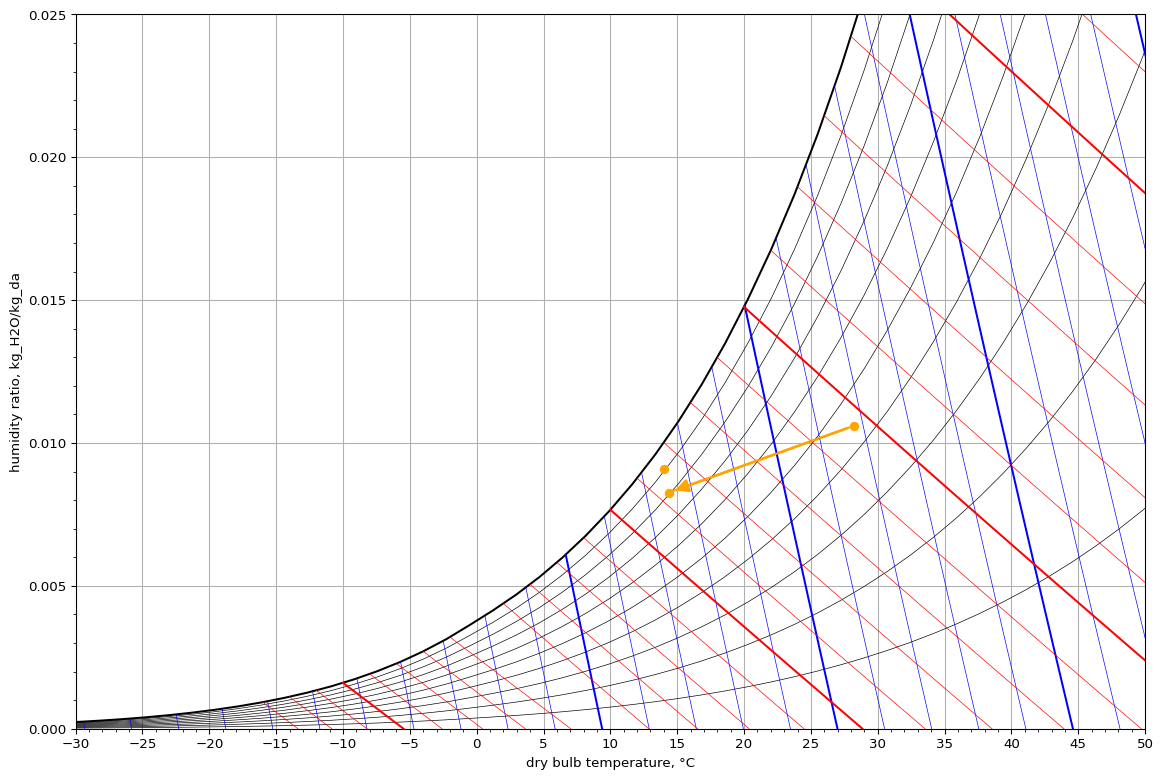

In [24]:
psy_chart = PsychrometricChart()
psy_chart.plot_process(
    name='cooling coil',
    start_point=start,
    end_point=end
)
psy_chart.plot_point(
    name='target',
    point=target
)
psy_chart.show()